#  Recommendation System for Netflix Prize Dataset using SVD

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# To load the 'combined_data_1' dataset after uploading it to Jupyter notebook

In [2]:
# Reading dataset file
dataset = pd.read_csv('/Users/samyakjain/Downloads/combined_data_1.txt',header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

# Convert Ratings column to a float
dataset['Rating'] = dataset['Rating'].astype(float)

In [3]:
#To print the datatype of columns
dataset.dtypes

Cust_Id     object
Rating     float64
dtype: object

In [4]:
#To inspect the shape of the datset
dataset.shape



(24058263, 2)

In [5]:
#To print the head of dataset
dataset.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [6]:
#To find the distribution of different ratings in the datset
p = dataset.groupby('Rating')['Rating'].agg(['count'])

p

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


In [7]:
# get movie count by counting nan values

movie_count = dataset.isnull().sum()[1]

movie_count

4499

In [8]:
# get customer count
cust_count = dataset['Cust_Id'].nunique()-movie_count

cust_count

470758

In [9]:
# get rating count

rating_count = dataset['Cust_Id'].count() - movie_count

rating_count

24053764

## To plot the distribution of the ratings in as a bar plot

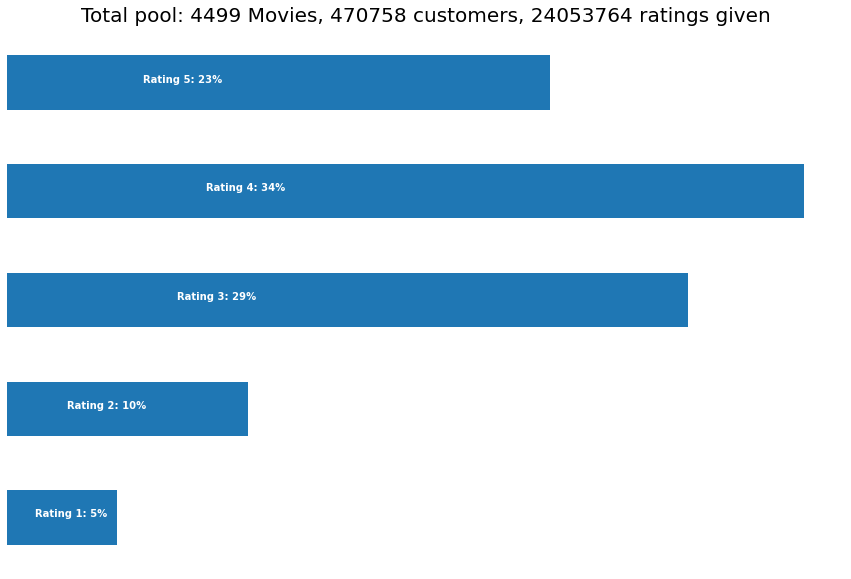

In [10]:
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title(f'Total pool: {movie_count} Movies, {cust_count} customers, {rating_count} ratings given', fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

# To create a numpy array containing movie ids corresponding to the rows in the 'ratings' dataset

In [11]:
# To count all the 'nan' values in the Ratings column in the 'ratings' dataset
df_nan = pd.DataFrame(pd.isnull(dataset.Rating), )

df_nan.head()

,Rating
0,True
1,False
2,False
3,False
4,False


In [12]:
# To store the index of all the rows containing 'nan' values
df_nan = df_nan[df_nan['Rating'] == True]


df_nan.shape

(4499, 1)

In [13]:
# To reset the index of the dataframe
df_nan = df_nan.reset_index()



df_nan.head()

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True


In [14]:
#To create a numpy array containing movie ids according the 'ratings' dataset

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(dataset) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print(f'Movie numpy: {movie_np}')
print(f'Length: {len(movie_np)}')

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [15]:
#x =zip(df_nan['index'][1:],df_nan['index'][:-1])

In [16]:
#temp = np.full((1,547), 1)

In [17]:
#print(temp)

In [18]:
#tuple(x)

In [19]:
#To append the above created array to the datset after removing the 'nan' rows
dataset = dataset[pd.notnull(dataset['Rating'])]

dataset['Movie_Id'] = movie_np.astype(int)
dataset['Cust_Id'] =dataset['Cust_Id'].astype(int)
print('-Dataset examples-')
dataset.head()

-Dataset examples-


,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [20]:
dataset.shape

(24053764, 3)

# Data Cleaning

In [21]:
f = ['count','mean']



In [22]:
#To create a list of all the movies rated less often(only include top 30% rated movies)
dataset_movie_summary = dataset.groupby('Movie_Id')['Rating'].agg(f)

dataset_movie_summary.index = dataset_movie_summary.index.map(int)

movie_benchmark = round(dataset_movie_summary['count'].quantile(0.7),0)

drop_movie_list = dataset_movie_summary[dataset_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

Movie minimum times of review: 1799.0


In [23]:
#To create a list of all the inactive users(users who rate less often)
dataset_cust_summary = dataset.groupby('Cust_Id')['Rating'].agg(f)
dataset_cust_summary.index = dataset_cust_summary.index.map(int)
cust_benchmark = round(dataset_cust_summary['count'].quantile(0.7),0)
drop_cust_list = dataset_cust_summary[dataset_cust_summary['count'] < cust_benchmark].index

print(f'Customer minimum times of review: {cust_benchmark}')

Customer minimum times of review: 52.0


In [24]:
print(f'Original Shape: {dataset.shape}')


Original Shape: (24053764, 3)


In [25]:
dataset = dataset[~dataset['Movie_Id'].isin(drop_movie_list)]
dataset = dataset[~dataset['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(dataset.shape))

After Trim Shape: (17337458, 3)


In [26]:

print('-Data Examples-')
dataset.head()

-Data Examples-


,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3


# Create ratings matrix for 'ratings' matrix with Rows = userId, Columns = movieId

In [27]:
df_p = pd.pivot_table(dataset,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(143458, 1350)


In [28]:
df_p.head()

Movie_Id,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,...,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### To load the movie_titles dataset

In [29]:
df_title = pd.read_csv('/Users/samyakjain/Downloads/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])

df_title.set_index('Movie_Id', inplace = True)

print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


# To install the scikit-surprise library for implementing SVD

### Run the following command in the Anaconda Prompt to install surprise package

In [32]:
conda install -c conda-forge scikit-surprise

Solving environment: done

## Package Plan ##

  environment location: /Users/samyakjain/opt/anaconda3

  added / updated specs:
    - scikit-surprise


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.2                |   py38h50d1736_0         3.1 MB  conda-forge
    python_abi-3.8             |           1_cp38           4 KB  conda-forge
    scikit-surprise-1.1.1      |   py38h174b24a_1         586 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.7 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/osx-64::python_abi-3.8-1_cp38
  scikit-surprise    conda-forge/osx-64::scikit-surprise-1.1.1-py38h174b24a_1

The following packages will be SUPERSEDED by a higher-priority channel:

  conda               pkgs/main::conda-4.9.2-py38hecd8cb5_0 --> conda-forge:

In [33]:
# Import required libraries
import math
import re
import matplotlib.pyplot as plt

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [34]:
# Load Reader library
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(dataset[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)

# Use the SVD algorithm.
svd = SVD()

# Compute the RMSE of the SVD algorithm
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9981  0.9970  0.9988  0.9980  0.0007  
MAE (testset)     0.8038  0.7964  0.7992  0.7998  0.0030  
Fit time          3.36    3.03    3.01    3.13    0.16    
Test time         0.22    0.13    0.14    0.16    0.04    


{'test_rmse': array([0.99805285, 0.99702348, 0.99880481]),
 'test_mae': array([0.80375021, 0.79638468, 0.79918846]),
 'fit_time': (3.3555712699890137, 3.034126043319702, 3.014935255050659),
 'test_time': (0.21656107902526855, 0.1326127052307129, 0.1391279697418213)}

In [35]:
dataset.head()

,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3


## To find all the movies rated as 5 stars by user with userId = 712664

In [36]:
dataset_712664 = dataset[(dataset['Cust_Id'] == 712664) & (dataset['Rating'] == 5)]
dataset_712664 = dataset_712664.set_index('Movie_Id')
dataset_712664 = dataset_712664.join(df_title)['Name']
dataset_712664.head(10)

Movie_Id
3                              Character
79                           The Killing
175                       Reservoir Dogs
199                      The Deer Hunter
241                   North by Northwest
256    Ghost Dog: The Way of the Samurai
348        The Last Temptation of Christ
357                House of Sand and Fog
416                             Elephant
442                  Mississippi Burning
Name: Name, dtype: object

# Train an SVD to predict ratings for user with userId = 1

In [37]:
# Create a shallow copy for the movies dataset
user_712664 = df_title.copy()

user_712664 = user_712664.reset_index()

#To remove all the movies rated less often 
user_712664 = user_712664[~user_712664['Movie_Id'].isin(drop_movie_list)]


# getting full dataset
data = Dataset.load_from_df(dataset[['Cust_Id', 'Movie_Id', 'Rating']], reader)

#create a training set for svd
trainset = data.build_full_trainset()
svd.fit(trainset)

#Predict the ratings for user_712664
user_712664['Estimate_Score'] = user_712664['Movie_Id'].apply(lambda x: svd.predict(712664, x).est)

#Drop extra columns from the user_712664 data frame
user_712664 = user_712664.drop('Movie_Id', axis = 1)

# Sort predicted ratings for user_712664 in descending order
user_712664 = user_712664.sort_values('Estimate_Score', ascending=False)

#Print top 10 recommendations
print(user_712664.head(10))

        Year                               Name  Estimate_Score
174   1992.0                     Reservoir Dogs        5.000000
871   1954.0                      Seven Samurai        5.000000
721   2003.0                 The Wire: Season 1        5.000000
2101  1994.0             The Simpsons: Season 6        5.000000
2171  1991.0             The Simpsons: Season 3        5.000000
3045  1990.0  The Simpsons: Treehouse of Horror        5.000000
1019  1989.0             The Simpsons: Season 1        4.988188
3289  1974.0                      The Godfather        4.944698
560   1963.0                       High and Low        4.943651
4114  1999.0            The Simpsons: Bart Wars        4.929402
